In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
%load_ext tensorboard

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime, os
from PIL.Image import *
import urllib.request


print(tf.__version__)


2.4.0


In [2]:

path = '/home/marie/Bureau/datasets/100datas/train'
PATH = os.path.dirname(path)

dirset = os.path.join(PATH, 'train')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset=image_dataset_from_directory(dirset,
                            shuffle=True,
                            seed=1337,
                            batch_size=BATCH_SIZE,
                            image_size=IMG_SIZE,
                            validation_split=0.2,
                            subset="training")
validation_dataset=image_dataset_from_directory(dirset,
                            shuffle=True,
                            seed=1337,
                            batch_size=BATCH_SIZE,
                            image_size=IMG_SIZE,
                            validation_split=0.2,
                            subset="validation")


Found 80 files belonging to 2 classes.
Using 64 files for training.
Found 80 files belonging to 2 classes.
Using 16 files for validation.


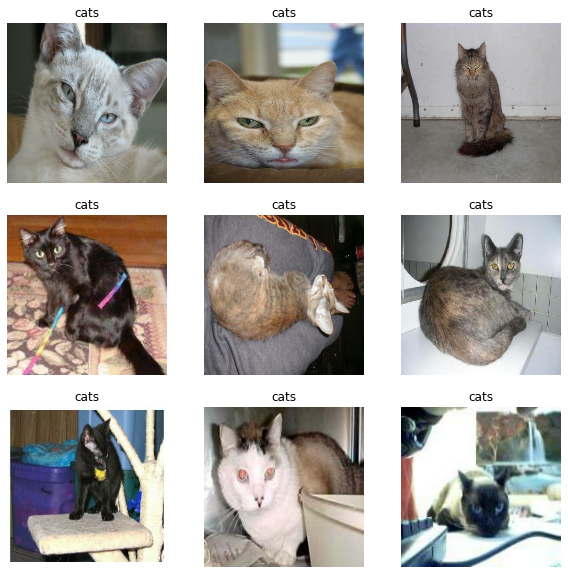

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 1
Number of test batches: 0


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


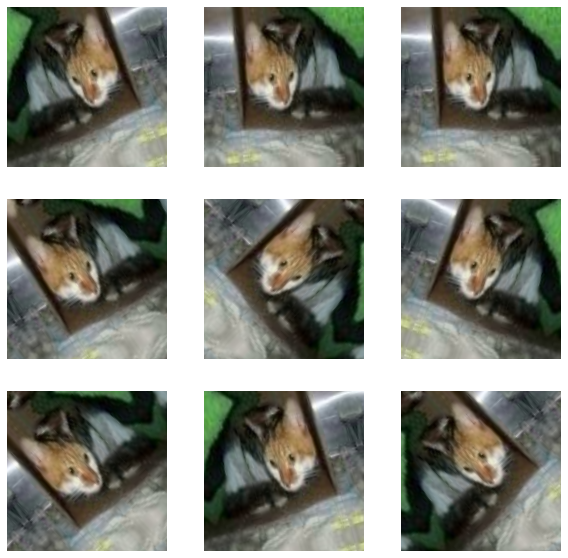

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [13]:
# Freeze the pre-trained model weights
base_model.trainable = True


# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = maxpool_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)



# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Layer classification head with feature detector

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = maxpool_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

learning_rate = 0.0001



# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
)

(32, 1280)
(32, 1)
Number of layers in the base model:  154


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [15]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 1s 1s/step - loss: 3.2333 - accuracy: 0.2500


In [16]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 3.23
initial accuracy: 0.25


In [17]:
# Train the model with the new callback

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history= model.fit(train_dataset,  
          epochs=initial_epochs,
          validation_data=validation_dataset,
          callbacks=[tensorboard_callback])  

%tensorboard --logdir logs

Epoch 1/20
2/2 [==============================] - 6s 1s/step - loss: 2.9371 - accuracy: 0.2969 - val_loss: 4.1482 - val_accuracy: 0.1875
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 1.3386 - accuracy: 0.6562 - val_loss: 4.2176 - val_accuracy: 0.1875
Epoch 3/20
2/2 [==============================] - 3s 2s/step - loss: 0.7880 - accuracy: 0.7188 - val_loss: 4.7030 - val_accuracy: 0.1875
Epoch 4/20
2/2 [==============================] - 3s 2s/step - loss: 0.1331 - accuracy: 0.9531 - val_loss: 4.5438 - val_accuracy: 0.1875
Epoch 5/20
2/2 [==============================] - 3s 2s/step - loss: 0.1991 - accuracy: 0.9062 - val_loss: 4.1693 - val_accuracy: 0.1875
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 0.0765 - accuracy: 0.9688 - val_loss: 3.7826 - val_accuracy: 0.1875
Epoch 7/20
2/2 [==============================] - 3s 2s/step - loss: 0.1792 - accuracy: 0.9375 - val_loss: 3.8875 - val_accuracy: 0.1875
Epoch 8/20
2/2 [=========================

Reusing TensorBoard on port 6006 (pid 119174), started 3:48:13 ago. (Use '!kill 119174' to kill it.)

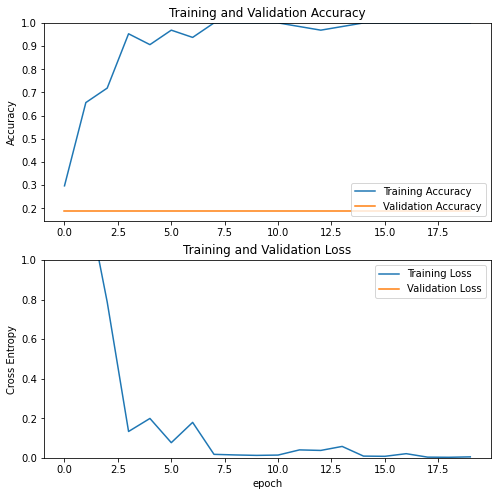

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)



OverflowError: cannot convert float infinity to integer

In [20]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


StopIteration: 

In [22]:
model.save('my_model100datas.h5')


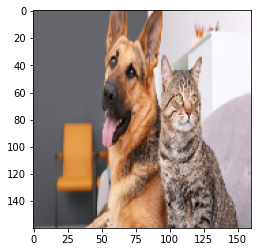

(1, 160, 160, 3)


In [27]:
#img_path = 'https://live.staticflickr.com/5504/14187029688_46e25edbf1_k.jpg'
#img_path = 'https://www.jardiner-malin.fr/wp-content/uploads/2019/03/berger-australien-1.jpg'
img_path = 'https://static.wamiz.com/images/news/facebook/article/chat-chien-fb-5cd3fd85b2eae.jpg'
im=urllib.request.urlretrieve(img_path, "sample.png")

img = tf.keras.preprocessing.image.load_img("sample.png", target_size=(160, 160))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [28]:
# predicting images
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict_on_batch(images).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(classes)
predictions = tf.where(classes < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print("Predicted class is:",class_names[predictions[0]])

Predictions:
 [1]
Predicted class is: dogs
